In [1]:
# %%capture --no-stderr
# %pip install --quiet -U langgraph

In [2]:
from pydantic import BaseModel
from typing import Optional
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [3]:
# -------------------------
# 1. State Definition
# -------------------------
class State(BaseModel):
    input: str
    user_feedback: Optional[str] = None  # ✅ FIX: Optional with default

In [4]:
# -------------------------
# 2. Nodes
# -------------------------
def step_A(state: State) -> State:
    print("Step_A executed")
    return state

def human_feedback(state: State) -> State:
    # This node will be interrupted before execution
    print("Human Feedback Node")
    return state

def step_B(state: State) -> State:
    print("Step_B executed")
    print("User feedback received:", state.user_feedback)
    return state

def step_C(state: State) -> State:
    print("Step_C executed")
    print("User feedback received:", state.user_feedback)
    return state

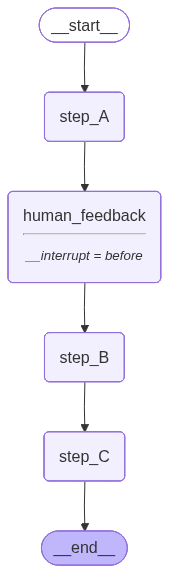

In [5]:
# -------------------------
# 3. Build Graph
# -------------------------
builder = StateGraph(State)

builder.add_node("step_A", step_A)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_B", step_B)
builder.add_node("step_C", step_C)

builder.add_edge(START, "step_A")
builder.add_edge("step_A", "human_feedback")
builder.add_edge("human_feedback", "step_B")
builder.add_edge("step_B", "step_C")
builder.add_edge("step_C", END)

# -------------------------
# 4. Memory Checkpointer
# -------------------------
memory = MemorySaver()

graph = builder.compile(
    checkpointer=memory,
    interrupt_before=["human_feedback"]  # ✅ Human-in-the-loop
)

graph

In [6]:
# -------------------------
# 5. Initial Input (VALID)
# -------------------------
initial_input = {"input": "Hello World"}

thread = {"configurable": {"thread_id": "1"}}

# -------------------------
# 6. Run Until Interruption
# -------------------------
print("\n--- Running graph until interruption ---\n")

for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

# -------------------------
# 7. Inspect State Before Update
# -------------------------
print("\n--- State before human feedback ---")
print(graph.get_state(thread).values)


--- Running graph until interruption ---

{'input': 'Hello World'}
Step_A executed
{'input': 'Hello World'}

--- State before human feedback ---
{'input': 'Hello World'}


In [7]:
# 8. Get user input
user_input = input("Tell me how you want to update the state: ")

# 9. We now update the state as if we are the human_feedback node
graph.update_state(thread, {"user_feedback": user_input}, as_node="human_feedback")

# 10. We can check the state
print("\n--- State after update ---")
print(graph.get_state(thread).values)

# 11. We can check the next nodel showing that it is human_feedback node
graph.get_state(thread).next

Tell me how you want to update the state:  approved



--- State after update ---
{'input': 'Hello World', 'user_feedback': 'approved'}


('step_B',)

In [8]:
# 12. If approved, continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)


{'input': 'Hello World', 'user_feedback': 'approved'}
Step_B executed
User feedback received: approved
{'input': 'Hello World', 'user_feedback': 'approved'}
Step_C executed
User feedback received: approved
{'input': 'Hello World', 'user_feedback': 'approved'}
